In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=16

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train/", seed=123, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test/", seed=123, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val/", seed=123, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

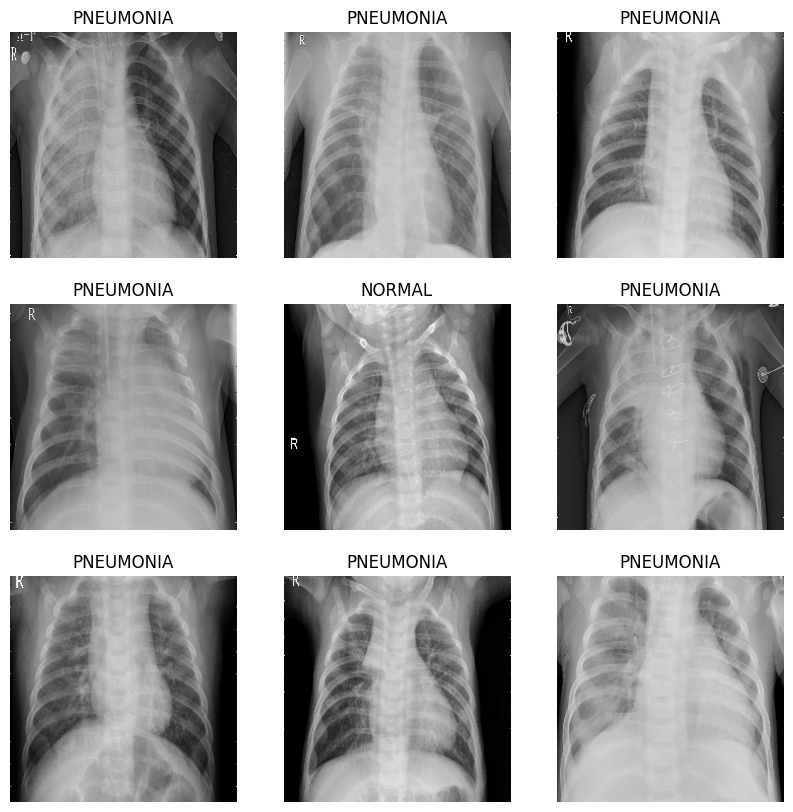

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch)
    break

(16, 224, 224, 3)
tf.Tensor([1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])



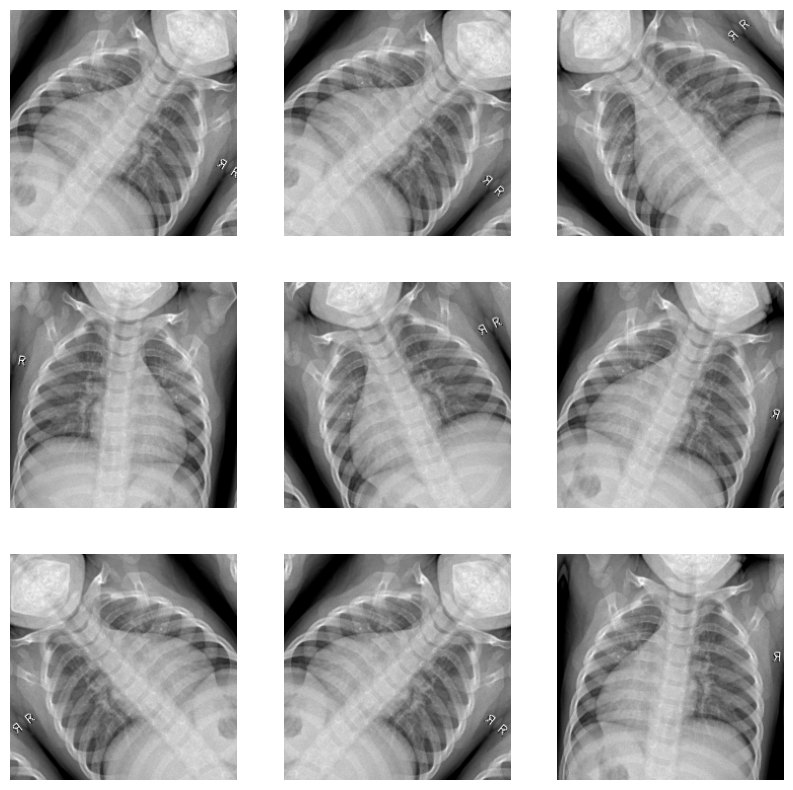

In [15]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [66]:
preprocess_input = tf.keras.applications.resnet.preprocess_input 

In [67]:
IMG_SHAPE = [224,224,3]
base_model = tf.keras.applications.ResNet101(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


In [68]:
base_model.trainable = False

In [69]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [70]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [71]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 2)


In [72]:
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [73]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0   

In [74]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
326/326 [==============================] - 28s 66ms/step - loss: 0.7816 - accuracy: 0.6829 - val_loss: 0.6931 - val_accuracy: 0.6875
Epoch 2/50
326/326 [==============================] - 19s 60ms/step - loss: 0.7010 - accuracy: 0.6371 - val_loss: 0.6931 - val_accuracy: 0.6875
Epoch 3/50
326/326 [==============================] - 19s 60ms/step - loss: 0.6998 - accuracy: 0.6609 - val_loss: 0.6931 - val_accuracy: 0.6250
Epoch 4/50
326/326 [==============================] - 20s 60ms/step - loss: 0.6955 - accuracy: 0.6885 - val_loss: 0.6931 - val_accuracy: 0.6250
Epoch 5/50
326/326 [==============================] - 19s 60ms/step - loss: 0.6952 - accuracy: 0.6676 - val_loss: 0.6931 - val_accuracy: 0.6250
Epoch 6/50
326/326 [==============================] - 20s 60ms/step - loss: 0.6941 - accuracy: 0.6752 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/50
326/326 [==============================] - 20s 60ms/step - loss: 0.6926 - accuracy: 0.7362 - val_loss: 0.6931 - val_accuracy:

In [76]:
loss0, accuracy0 = model.evaluate(val_ds)

1/1 [==============================] - 0s 66ms/step - loss: 0.6931 - accuracy: 0.6250


In [101]:
iterator = iter(test_ds)
image_batch, label_batch = iterator.next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)


In [102]:
print(predictions.numpy())

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [103]:
print(label_batch)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
